In [1]:
import fitsio
import os
import os.path
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import tensorflow as tf
from astropy.io import fits
import astropy
import json

In [2]:
## to build dataset, run: tfds build --data_dir=/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_all --register_checksums

Sloan data at NERSC is stored in this directory

In [3]:
hdulist = fits.open("/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/plates-dr16.fits")

hdulist[1].data['PLATEQUALITY']

chararray(['bad', 'good', 'good', ..., 'good', 'good', 'good'],
          dtype='<U8')

In [66]:
plates = hdulist[1].data['PLATE']
mjds   = hdulist[1].data['MJD']
platequality = hdulist[1].data['PLATEQUALITY']
#hdulist[1].data['PLATEID']
print(len(plates))
endings = np.unique(hdulist[1].data['RUN2D'])
print(endings)

6826
['103' '104' '26' 'v5_13_0']


In [67]:
good_plates = np.where(platequality=='good')

In [68]:
good_data = {}

In [69]:

plates = plates[good_plates]
mjds   = mjds[good_plates]
folder = hdulist[1].data['RUN2D'][good_plates]

count = 0 
for tag in np.unique(folder):
    good_data[tag]={}
    good_data[tag]['plates']=plates[folder==tag]
    good_data[tag]['mjds']=mjds[folder==tag]
    count+=len(mjds[folder==tag])
print(count)

6062


In [28]:
# char1 = '-'
# char2 = '.'
# test = 'spPlate-6283-56239.fits'
# this_mjd = np.int(test[-10:-5])
# this_plate = np.int(test[test.find(char1)+1 : test.find(char2)-6])

# print(this_mjd, this_plate)

56239 6283


Data is in subdirectories.

Spectra are organied by plate.

For the moment work with "combined" spectra.  A single object may be observed several times and the spectrograph has blue and red channels.  These data are available but the simple thing is to work where these data are combined to make one spectrum per object.

The combined spectra for the plate are in fits files with the name "spPlate*.fits

see https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/spPlate.html

In [14]:
endings

chararray(['103', '104', '26', 'v5_13_0'], dtype='<U7')

In [70]:
# save the names of the data and redshift files
char1 = '-'
char2 = '.'
datafiles_wz=[]
datafiles_nz=[]
z_files=[]
for ending in endings:
    sdss_dir = os.path.join("/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/", ending)
    for dirpath, dirnames, filenames in os.walk(sdss_dir):
        for filename in [f for f in filenames if f.startswith("spPlate")]:
            try:
                this_plate = np.int(filename[filename.find(char1)+1 : filename.find(char2)-6])
                this_mjd   = np.int(filename[-10:-5])
            except:
                print(filename)
            if this_plate in good_data[ending]['plates']:
                ind = np.where(good_data[ending]['plates']==this_plate)[0]
                if this_mjd in good_data[ending]['mjds'][ind]:
                    data_file   = os.path.join(dirpath, filename)
                    file_ending = filename[7::]
                    if ending=='v5_13_0':
                        z_file      = os.path.join(dirpath,ending,'spZbest'+file_ending)
                    else:
                        z_file      = os.path.join(dirpath,'spZbest'+file_ending)
                    if os.path.exists(z_file):
                        z_files.append(z_file)
                        datafiles_wz.append(os.path.join(dirpath, data_file))
                    else:
                        datafiles_nz.append(os.path.join(dirpath, data_file))
                        print(z_file)

/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/103/2887/pass2/spZbest-2887-54521.fits
/global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/103/2887/pass1/spZbest-2887-54521.fits
spPlate-1962-53321.fits.save
spPlate-1963-54331.fits.save
spPlate-2247-53857.fits.save
spPlate-2667-54142.fits.save
spPlate-2912-54499.fits.save
spPlate-2174-53521.fits.save
spPlate-2255-53565.fits.save
spPlate-2800-54326.fits.save
spPlate-2256-53613.fits.save
spPlate-2256-53859.fits.save
spPlate-2377-53991.fits.save
spPlate-2078-53378.fits.save
spPlate-2338-53679.fits.save
spPlate-1960-53289.fits.save
spPlate-2079-53379.fits.save
spPlate-2185-53532.fits.save
spPlate-1961-53299.fits.save
spPlate-2671-54141.fits.save
spPlate-2333-53676.fits.save
spPlate-2821-54393.fits.save
spPlate-2887-54521.fits.save
spPlate-2475-53845.fits.save
spPlate-2476-53826.fits.save


In [71]:
print(len(datafiles_wz))
print(len(z_files)+len(datafiles_nz))

6062
6064


In [72]:
local_path = '/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data/'


In [73]:
with open(os.path.join(local_path,'datafiles_good.txt'), 'w') as file:
    json.dump(datafiles_wz, file)

In [74]:
with open(os.path.join(local_path,'z_files_good.txt'), 'w') as file:
    json.dump(z_files, file)

In [75]:
with open(os.path.join(local_path,'z_files_good.txt'), 'r') as infile:
    for line in infile:
        z_files = json.loads(line)


## Look at one file

In [34]:
h    = fitsio.read_header(z_files[0])

In [35]:
h    = fitsio.FITS(z_files[0])

In [52]:
for ii, (datafile, zfile) in enumerate(zip(datafiles_wz[0:8],z_files[0:8])):
    print(ii)
    hdulist = fits.open(zfile)

0
1
2
3
4
5
6
7


In [53]:
hdulist[1].data.field('SPECOBJID')

array([5858057591415132160, 5858057866293039104, 5858058141170946048,
       5858058416048852992, 5858058690926759936, 5858058965804666880,
       5858059240682573824, 5858059515560480768, 5858059790438387712,
       5858060065316294656, 5858060340194201600, 5858060615072108544,
       5858060889950015488, 5858061164827922432, 5858061439705829376,
       5858061714583736320, 5858061989461643264, 5858062264339550208,
       5858062539217457152, 5858062814095364096, 5858063088973271040,
       5858063363851177984, 5858063638729084928, 5858063913606991872,
       5858064188484898816, 5858064463362805760, 5858064738240712704,
       5858065013118619648, 5858065287996526592, 5858065562874433536,
       5858065837752340480, 5858066112630247424, 5858066387508154368,
       5858066662386061312, 5858066937263968256, 5858067212141875200,
       5858067487019782144, 5858067761897689088, 5858068036775596032,
       5858068311653502976, 5858068586531409920, 5858068861409316864,
       5858069136287

In [37]:
new_file_names = "/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data/"


for ii, (datafile, zfile) in enumerate(zip(datafiles_wz[0:8],z_files[0:8])):
    print(ii)
    hdulist = fits.open(datafile)
    print(hdulist[0].header)
    c0   = hdulist[0].header['coeff0']
    c1   = hdulist[0].header['coeff1']
    npix = hdulist[0].header['naxis1']
    wave = 10.**(c0 + c1 * np.arange(npix))

    bunit = hdulist[0].header['bunit']
    print(bunit)
    flux  = hdulist[0].data
    ivar  = hdulist[1].data
    amask = np.asarray(hdulist[2].data==0,dtype=int)
    hdulist.close()
    hdulist = 0

    #hdulist = fits.open(z_file)
    zstruc  = hdulist[1].data
    print(z_struc['z'])
#     hdulist.close()
#     hdulist = 0

    hdu       = fits.PrimaryHDU(flux)
    hdu_amask = fits.ImageHDU(amask,name='amask')
    hdu_ivar  = fits.ImageHDU(amask,name='ivar')
    hdu_wave  = fits.ImageHDU(wave,name='wlen')

    
#     c1 = fits.Column(name='redshift', array=zstruc['z'], format='E')
#     c2 = fits.Column(name='class', array=zstruc['class'], format='6A')
#     c3 = fits.Column(name='subclass', array=zstruc['subclass'], format='6A')
#     c4 = fits.Column(name='index', array=ii*1000+np.arange(1000), format='K')

#    cdef = fits.ColDefs([c1,c2,c3,c4])

#    table_hdu = fits.BinTableHDU.from_columns(cdef)

    hdulist = fits.HDUList([hdu, hdu_amask, hdu_ivar, hdu_wave])
    hdulist.writeto(os.path.join(new_file_names,'spAll%d.fits'%ii))
#     hdulist.close()
#     hdulist = 0



0
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 4647 /                                                NAXIS2  =                 1000 /                                                EXTEND  =                    T /                                                TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       NGUIDE  =              41.0000 / Number of guider frames during exposure        SEEING20=              1.77637 / 20% seeing during exposure (arcsec)            SEEING50=              1.92245 / 50% seeing during exposure (arcsec)            SEEING80=              2.09064 / 80% seeing during exposure (arcsec)            RMSOFF20=      0.0113732020000 / 20% RMS offset of guide fibers (arcsec)        RMSOFF50=      0.0192252700000 / 50% R

TypeError: 'int' object is not subscriptable

In [40]:
hdulist = fits.open(os.path.join(new_file_names,'spAll%d.fits'%0))

In [58]:
name = os.path.join(new_file_names,'spAll%d.fits'%0)

In [18]:
# ff = fits.open(name)

# for ii in range(10):
#     data =1*fits.getdata(name, 0).astype('float32')
#     print(data.shape)
#     im = tf.expand_dims(data[ii],-1)
#     print(im)

In [34]:
pp=hdulist['PRIMARY'].data

In [35]:
pp.shape

(1000, 4647)

In [36]:
pp[0]

array([ 16.493845 ,   7.7203794,   7.1141124, ..., -18.153131 ,
       -18.152998 , -18.152863 ], dtype=float32)

In [105]:
h    = fitsio.read_header(datafiles[0])
fits = fitsio.FITS(datafiles[0])

In [50]:
# The wavelength solution is saved here
print(h["COEFF0"],h["COEFF1"])

3.5508 0.0001


In [42]:
wave = 10**(h["COEFF0"]+h["COEFF1"]*np.arange(4647))

In [20]:
img  = fits[0].read()
img.shape

(1000, 4647)

In [106]:
fits


  file: /global/project/projectdirs/cosmo/data/sdss/dr16/sdss/spectro/redux/v5_13_0/5290/spPlate-5290-55862.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       IVAR
  2      IMAGE_HDU       ANDMASK
  3      IMAGE_HDU       ORMASK
  4      IMAGE_HDU       WAVEDISP
  5      BINARY_TBL      PLUGMAP
  6      IMAGE_HDU       SKY

### Wavelengths
All spectra in a plate have the same wavelength solution.
All plates have very similar wavelength solutions.
Instead of being saved as an array, the wavelengths of the spectra are saved in the header.

3.5508 0.0001


### Flux, variance, and mask
The data include the flux (in physical units), inverse variance, masks that indicate a problem with a pixel

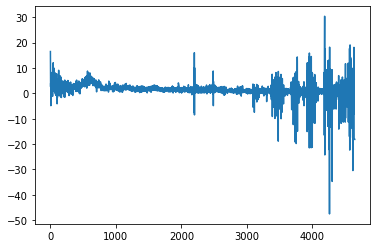

In [21]:
plt.plot(np.squeeze(fits[0][0,:]))

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from sdss_pae.sdss_dataset import SDSS

In [11]:
ds, info =tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/',with_info=True)

In [12]:
info

tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from spAll and s dataset in 
'flux': tfds.features.Tensor(shape=(None,1),dtype=tf.float32),
'inv_var': tfds.features.Tensor(shape=(None,1),dtype=tf.float32),
'and_mask': tfds.features.Tensor(shape=(None,1),dtype=tf.int32),
'coeffs': tfds.features.Tensor(shape=(3,1), dtype=tf.float32),
'label': tfds.features.ClassLabel(names=['STAR', 'QSO', 'GALAXY']),
'redshift': tfds.features.Tensor(shape=(),dtype=tf.float32),',
    homepage='https://www.sdss.org/science/data-release-publications/',
    features=FeaturesDict({
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'filename': Text(shape=(), dtype=tf.string),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'redshift': tf.flo

In [13]:
ds['train'].take(1)

<TakeDataset shapes: {and_mask: (None, 1), coeffs: (3, 1), filename: (), flux: (None, 1), inv_var: (None, 1), label: (), redshift: ()}, types: {and_mask: tf.int32, coeffs: tf.float32, filename: tf.string, flux: tf.float32, inv_var: tf.float32, label: tf.int64, redshift: tf.float32}>

In [14]:
ii = 0
for image in tfds.as_numpy(ds['train']):
    if ii<3:
        print(image['redshift'], image['label'])
        ii+=1


0.00020427242 0
1.514166 1
1.1216431 1
